# Import Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Import Library

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from itertools import cycle
import os

# Load Dataset

In [ ]:
file_path = '/content/gdrive/My Drive/Dataset/data_curah_hujan_sorong_final_2.csv'
df = pd.read_csv(file_path, sep=',', engine='python', on_bad_lines='skip')

print(f"Dataset berhasil dimuat dari '{file_path}'. Jumlah baris: {len(df)}")

Dataset berhasil dimuat dari '/content/gdrive/My Drive/Dataset/data_curah_hujan_sorong_final_2.csv'. Jumlah baris: 5540


# Preprocessing Data

In [ ]:
for col in ['Curah_Hujan_Harian_mm', 'Curah_Hujan_Kumulatif_24_Jam_mm',
            'Curah_Hujan_Kumulatif_48_Jam_mm', 'Curah_Hujan_Kumulatif_72_Jam_mm',
            'Lintang', 'Bujur', 'Elevasi_m']:
    if col in df.columns:
        if df[col].dtype == 'object': # Hanya proses jika tipe data adalah object (biasanya string)
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)
            print(f"Kolom '{col}' berhasil dikonversi ke float.")
        # Mengganti nilai -999.0 dengan NaN
        df[col] = df[col].replace(-999.0, np.nan)
    else:
        print(f"Peringatan: Kolom '{col}' tidak ditemukan di dataset.")

# Menangani nilai hilang (mengisi dengan median)
for col in ['Curah_Hujan_Harian_mm', 'Curah_Hujan_Kumulatif_24_Jam_mm',
            'Curah_Hujan_Kumulatif_48_Jam_mm', 'Curah_Hujan_Kumulatif_72_Jam_mm',
            'Lintang', 'Bujur', 'Elevasi_m']:
    if col in df.columns:
        # Tambahkan pengecekan ini untuk mengetahui jika ada null
        if df[col].isnull().sum() > 0:
            print(f"**TERDETEKSI NULL:** Kolom '{col}' memiliki {df[col].isnull().sum()} nilai null sebelum diisi.")

        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
    else:
        print(f"Peringatan: Kolom '{col}' tidak ditemukan di dataset.")

# Menghapus baris dengan target -1 (nilai yang tidak dikenal saat klasifikasi awal)
# Menambahkan pengecekan untuk memastikan kolom target ada sebelum mencoba mengaksesnya
if 'Potensi_Banjir_Prediksi' in df.columns:
    df = df[df['Potensi_Banjir_Prediksi'] != -1].copy()
    df['Potensi_Banjir_Prediksi'] = df['Potensi_Banjir_Prediksi'].astype(int) # Pastikan target adalah integer
else:
    print("Peringatan: Kolom 'Potensi_Banjir_Prediksi' tidak ditemukan di dataset. Skipping removal of -1 rows.")

print("\nDataset setelah pra-pemrosesan awal:")
df.info()
print("\nContoh 5 baris pertama dataset setelah pra-pemprosesan:")
print(df.head())

**TERDETEKSI NULL:** Kolom 'Curah_Hujan_Harian_mm' memiliki 10 nilai null sebelum diisi.
**TERDETEKSI NULL:** Kolom 'Curah_Hujan_Kumulatif_24_Jam_mm' memiliki 10 nilai null sebelum diisi.

Dataset setelah pra-pemrosesan awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5540 entries, 0 to 5539
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Alamat                           5540 non-null   object 
 1   Tanggal                          5540 non-null   object 
 2   Curah_Hujan_Harian_mm            5540 non-null   float64
 3   Curah_Hujan_Kumulatif_24_Jam_mm  5540 non-null   float64
 4   Curah_Hujan_Kumulatif_48_Jam_mm  5540 non-null   float64
 5   Curah_Hujan_Kumulatif_72_Jam_mm  5540 non-null   float64
 6   Lintang                          5540 non-null   float64
 7   Bujur                            5540 non-null   float64
 8   Elevasi_m                        5540 non-

/tmp/ipython-input-4-2039097384.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


# Visualisasi Data

/tmp/ipython-input-5-3706095586.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y="Alamat", order=df["Alamat"].value_counts().index, palette="viridis")


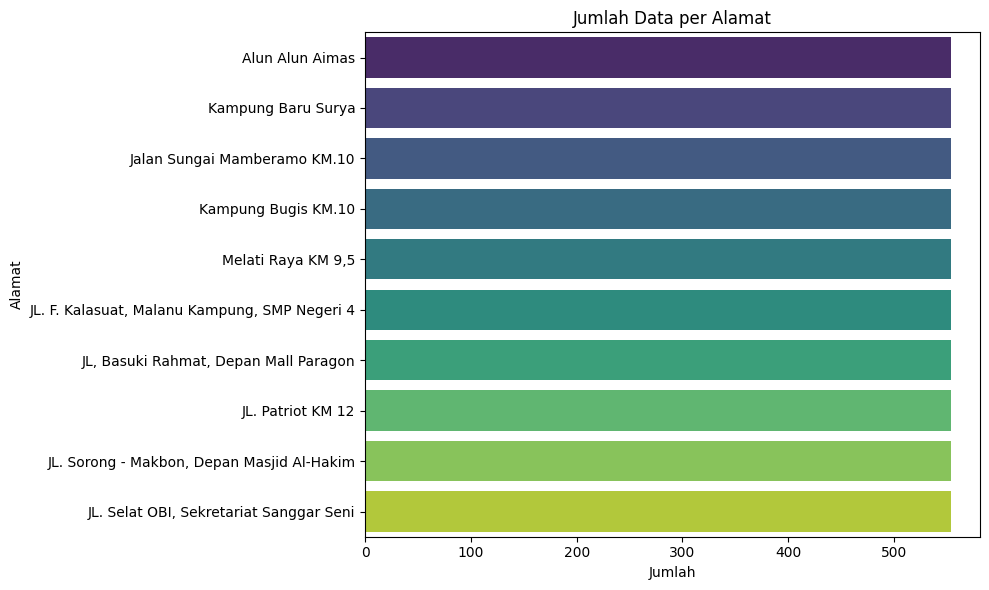

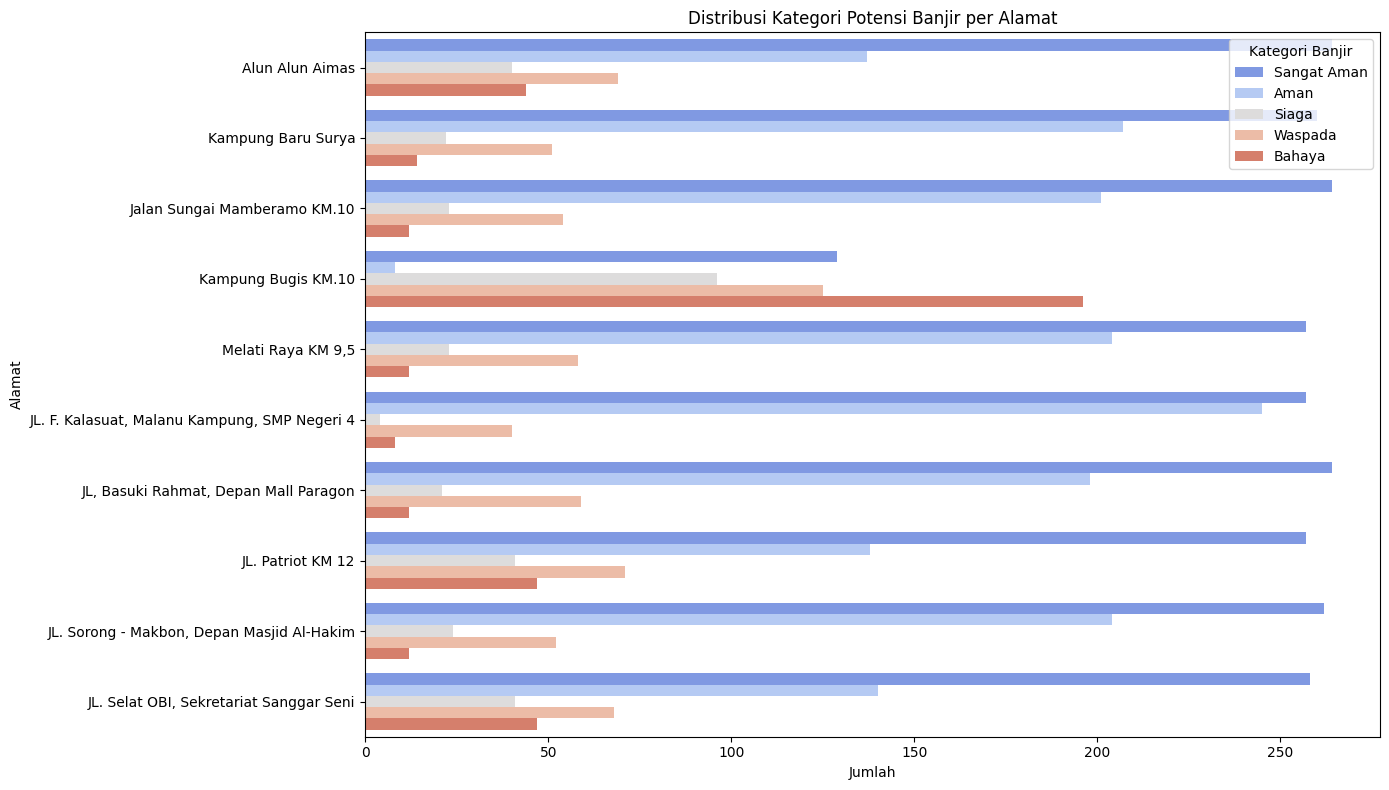

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, y="Alamat", order=df["Alamat"].value_counts().index, palette="viridis")
plt.title("Jumlah Data per Alamat")
plt.xlabel("Jumlah")
plt.ylabel("Alamat")
plt.tight_layout()
plt.show()

# Mapping label
label_mapping = {
    0: "Sangat Aman",
    1: "Aman",
    2: "Waspada",
    3: "Siaga",
    4: "Bahaya"
}
df["Kategori"] = df["Potensi_Banjir_Prediksi"].map(label_mapping)

plt.figure(figsize=(14, 8))
sns.countplot(data=df, y="Alamat", hue="Kategori", order=df["Alamat"].value_counts().index, palette="coolwarm")
plt.title("Distribusi Kategori Potensi Banjir per Alamat")
plt.xlabel("Jumlah")
plt.ylabel("Alamat")
plt.legend(title="Kategori Banjir")
plt.tight_layout()
plt.show()


# Split Features and Target

/tmp/ipython-input-6-831401232.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_label, palette="coolwarm", order=label_mapping.values())
/tmp/ipython-input-6-831401232.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_resampled_label, palette="coolwarm", order=label_mapping.values())


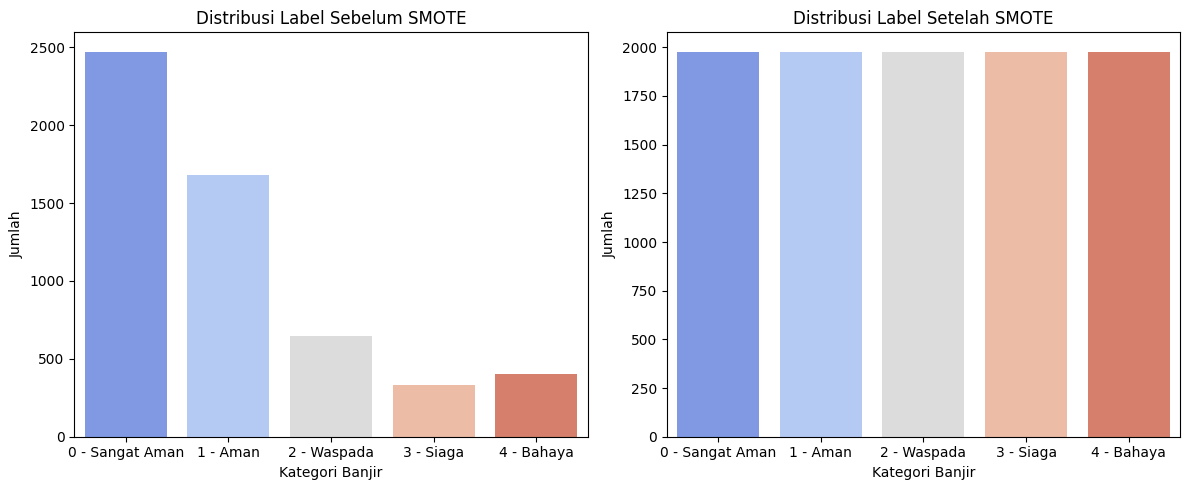

In [ ]:
features = ['Alamat', 'Curah_Hujan_Harian_mm', 'Curah_Hujan_Kumulatif_24_Jam_mm',
            'Curah_Hujan_Kumulatif_48_Jam_mm', 'Curah_Hujan_Kumulatif_72_Jam_mm',
            'Lintang', 'Bujur', 'Elevasi_m']
target = 'Potensi_Banjir_Prediksi'

X = df[features]
y = df[target]

# Mapping label angka ke teks
label_mapping = {
    0: "0 - Sangat Aman",
    1: "1 - Aman",
    2: "2 - Waspada",
    3: "3 - Siaga",
    4: "4 - Bahaya"
}

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Preprocessing pipeline
numeric_features = ['Curah_Hujan_Harian_mm', 'Curah_Hujan_Kumulatif_24_Jam_mm',
                    'Curah_Hujan_Kumulatif_48_Jam_mm', 'Curah_Hujan_Kumulatif_72_Jam_mm',
                    'Lintang', 'Bujur', 'Elevasi_m']
categorical_features = ['Alamat']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Transform
X_train_transformed = preprocessor.fit_transform(X_train)

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train_transformed, y_train)

# Convert label ke teks
y_label = y.map(label_mapping)
y_resampled_label = pd.Series(y_resampled).map(label_mapping)

# Plot distribusi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_label, palette="coolwarm", order=label_mapping.values())
plt.title("Distribusi Label Sebelum SMOTE")
plt.xlabel("Kategori Banjir")
plt.ylabel("Jumlah")

plt.subplot(1, 2, 2)
sns.countplot(x=y_resampled_label, palette="coolwarm", order=label_mapping.values())
plt.title("Distribusi Label Setelah SMOTE")
plt.xlabel("Kategori Banjir")
plt.ylabel("Jumlah")

plt.tight_layout()
plt.show()

# Build & Train Model MLP

In [ ]:
print("Memulai pelatihan MLP dengan early stopping")
mlp_exp3 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Tangani imbalance data
    ('classifier', MLPClassifier(
        hidden_layer_sizes=(100, 50),
        activation='relu',
        solver='adam',
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        n_iter_no_change=20,
        validation_fraction=0.1,
        verbose=False
    ))
])

mlp_exp3.fit(X_train, y_train)
y_pred_exp3 = mlp_exp3.predict(X_test)
accuracy_exp3 = accuracy_score(y_test, y_pred_exp3)
y_train_pred_exp3 = mlp_exp3.predict(X_train)
train_accuracy_exp3 = accuracy_score(y_train, y_train_pred_exp3)
print(f"Akurasi Model MLP Testing: {train_accuracy_exp3:.4f}")
print(f"Akurasi Model MLP : {accuracy_exp3:.4f}")
print("Classification Report (Eksperimen 3):")
print(classification_report(y_test, y_pred_exp3, zero_division=0))

final_mlp_model = mlp_exp3
final_y_pred = y_pred_exp3
final_accuracy = accuracy_exp3

print(f"\nModel memiliki akurasi: {final_accuracy:.4f}")

Memulai pelatihan MLP dengan early stopping
Akurasi Model MLP Testing: 0.9481
Akurasi Model MLP : 0.9386
Classification Report (Eksperimen 3):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       494
           1       0.94      0.92      0.93       337
           2       0.85      0.89      0.87       129
           3       0.89      0.81      0.84        67
           4       0.94      0.99      0.96        81

    accuracy                           0.94      1108
   macro avg       0.92      0.92      0.92      1108
weighted avg       0.94      0.94      0.94      1108


Model memiliki akurasi: 0.9386


# Evaluasi Model


--- Evaluasi Model MLP Final ---

--- Akurasi Model MLP pada Data Uji: 0.9386 ---

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       494
           1       0.94      0.92      0.93       337
           2       0.85      0.89      0.87       129
           3       0.89      0.81      0.84        67
           4       0.94      0.99      0.96        81

    accuracy                           0.94      1108
   macro avg       0.92      0.92      0.92      1108
weighted avg       0.94      0.94      0.94      1108


Confusion Matrix:


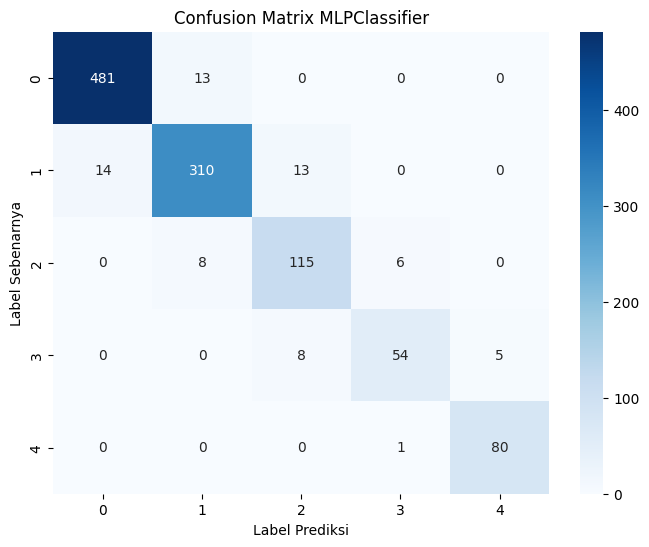

In [ ]:
print("\n--- Evaluasi Model MLP Final ---")
y_pred = final_mlp_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n--- Akurasi Model MLP pada Data Uji: {accuracy:.4f} ---")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
class_labels = sorted(y.unique())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Label Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix MLPClassifier')
plt.show()

# Grafik Evaluasi Model

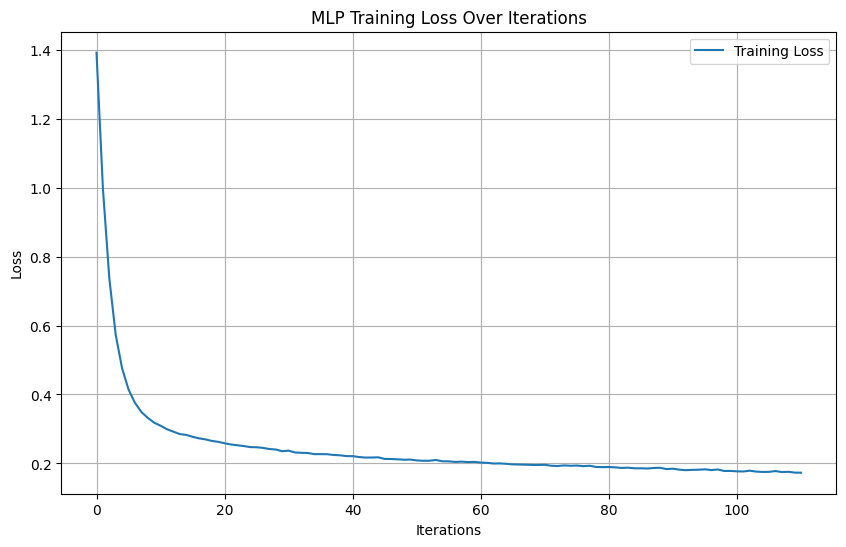


MLP Training Loss Plot displayed.

Calculating and plotting ROC Curve for multi-class (One-vs-Rest)...


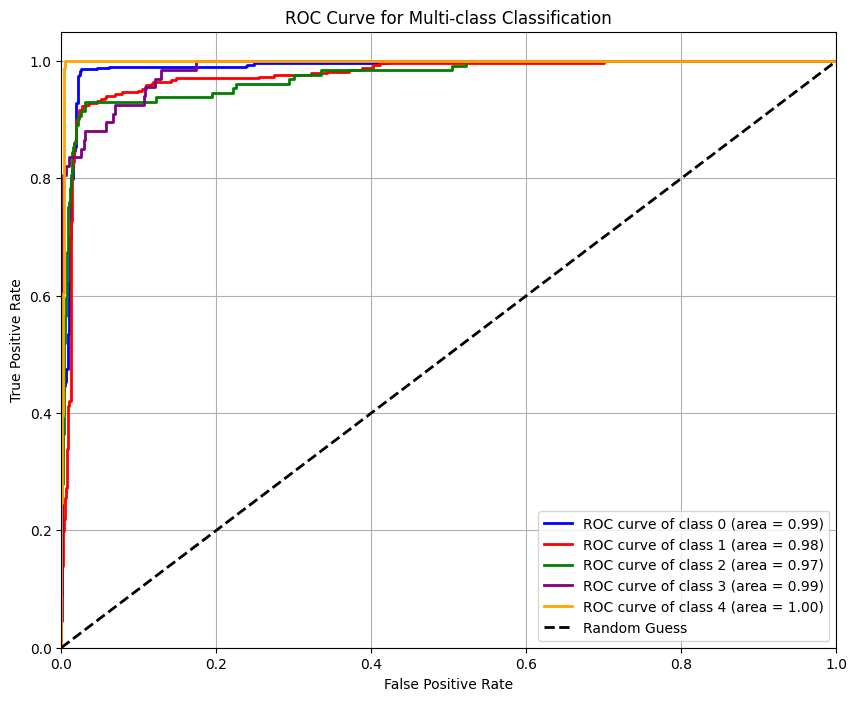

ROC Curve Plot displayed.

Calculating and plotting Precision-Recall Curve for multi-class (One-vs-Rest)...


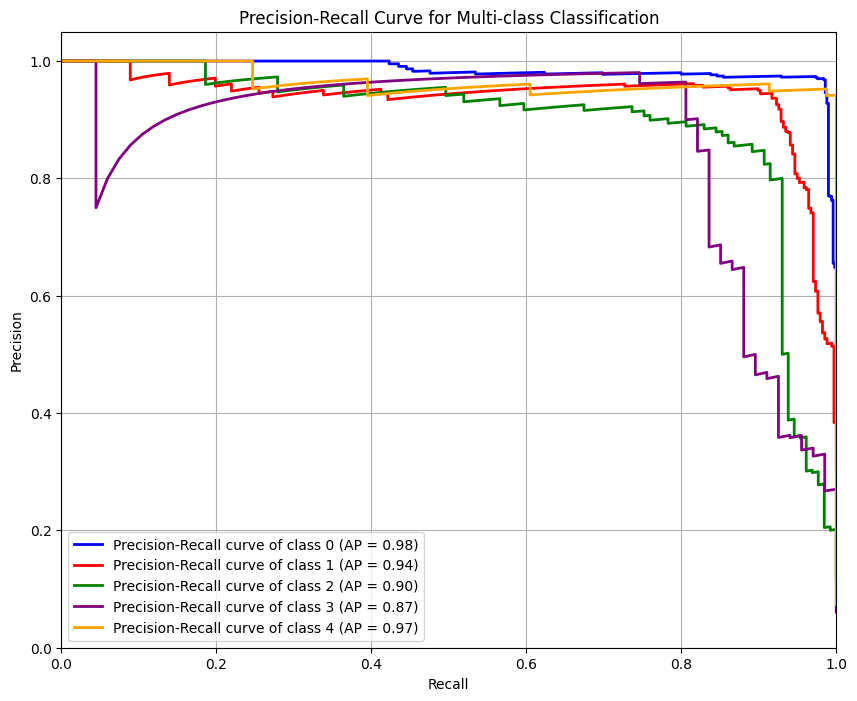

Precision-Recall Curve Plot displayed.


In [ ]:
if hasattr(final_mlp_model.named_steps['classifier'], 'loss_curve_'):
    plt.figure(figsize=(10, 6))
    plt.plot(final_mlp_model.named_steps['classifier'].loss_curve_, label='Training Loss')
    plt.title('MLP Training Loss Over Iterations')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.show()
    print("\nMLP Training Loss Plot displayed.")
else:
    print("\nLoss curve not available. Ensure the model has been trained.")

print("\nCalculating and plotting ROC Curve for multi-class (One-vs-Rest)...")
y_test_proba = final_mlp_model.predict_proba(X_test)

y_test_int = y_test.astype(int)
n_classes = len(np.unique(y_test_int))

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_int == i, y_test_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
print("ROC Curve Plot displayed.")

print("\nCalculating and plotting Precision-Recall Curve for multi-class (One-vs-Rest)...")

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_int == i, y_test_proba[:, i])
    average_precision[i] = average_precision_score(y_test_int == i, y_test_proba[:, i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Precision-Recall curve of class {class_labels[i]} (AP = {average_precision[i]:0.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-class Classification')
plt.legend(loc="lower left")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()
print("Precision-Recall Curve Plot displayed.")

# Save Model


In [ ]:
drive_path = "/content/gdrive/My Drive/Dataset/Model/"

model_filename = "mlp_banjir_model.joblib"
full_model_path = os.path.join(drive_path, model_filename)

joblib.dump(final_mlp_model, full_model_path)
print(f"\nMLP model successfully saved to Google Drive at: {full_model_path}")


MLP model successfully saved to Google Drive at: /content/gdrive/My Drive/Dataset/Model/mlp_banjir_model.joblib


# Load model

In [ ]:
import joblib

# Path model yang sudah disimpan sebelumnya
drive_path = "/content/gdrive/My Drive/Dataset/Model/"
model_filename = "mlp_banjir_model.joblib"
full_model_path = os.path.join(drive_path, model_filename)

# Load model dari file
loaded_model = joblib.load(full_model_path)


Tes Model

📍 Lokasi: Jalan Sungai Mamberamo KM.10
Kategori: 0 (Sangat Aman)


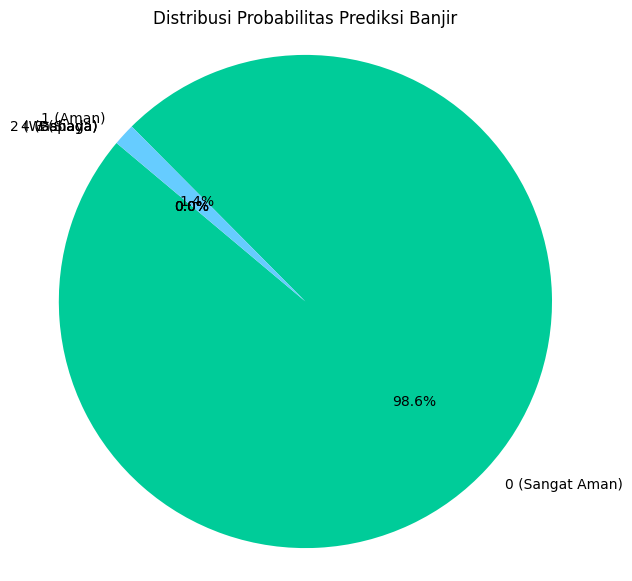

In [ ]:
import requests
import pandas as pd

# ===== SETTING =====
ADM4_CODE = "96.71.01.1001"
ALAMAT = "Remu Utara, Kota Sorong"
ELEVASI = 6.0
LAT = -0.8764480031
LON = 131.2833344279


def get_weather_features():
# ===== BMKG Data Fetch =====
    # Ambil lokasi random dari CSV
    df = pd.read_csv(file_path)
    sample = df.sample(n=1).iloc[0]

    # Ambil data curah hujan dari BMKG
    url = f"https://api.bmkg.go.id/publik/prakiraan-cuaca?adm4={ADM4_CODE}"
    res = requests.get(url, timeout=10)
    res.raise_for_status()
    data = res.json()

    cuaca_data = data["data"][0]["cuaca"]
    hujan_3jam = []
    for hari in cuaca_data[:3]:  # max 3 hari
        hujan_hari = [entry.get("tp", 0.0) for entry in hari]
        hujan_3jam.extend(hujan_hari)

    # Bagi jadi 3 hari (8 titik per hari)
    hujan_harian = [
        sum(hujan_3jam[i:i+8]) for i in range(0, min(len(hujan_3jam), 24), 8)
    ]

    # Return dict yang siap buat model prediksi
    return {
        "Alamat": sample["Alamat"],
        "Curah_Hujan_Harian_mm": hujan_harian[0] if hujan_harian else 0.0,
        "Curah_Hujan_Kumulatif_24_Jam_mm": sum(hujan_harian[:1]),
        "Curah_Hujan_Kumulatif_48_Jam_mm": sum(hujan_harian[:2]),
        "Curah_Hujan_Kumulatif_72_Jam_mm": sum(hujan_harian[:3]),
        "Lintang": sample["Lintang"],
        "Bujur": sample["Bujur"],
        "Elevasi_m": sample["Elevasi_m"],
        "Detail_Curah_Hujan_Per_Hari": hujan_harian
    }


# ===== Pie Chart Probabilitas =====
def plot_proba(prob):
    labels = ['0 (Sangat Aman)', '1 (Aman)', '2 (Waspada)', '3 (Siaga)', '4 (Bahaya)']
    colors = ['#00cc99', '#66ccff', '#ffcc00', '#ff9933', '#ff3333']

    plt.figure(figsize=(7, 7))
    plt.pie(prob, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title('Distribusi Probabilitas Prediksi Banjir')
    plt.axis('equal')
    plt.show()

# ===== Prediksi Model =====
def prediksi_banjir_multiclass(data_baru: pd.DataFrame):
    kelas = loaded_model.predict(data_baru)[0]
    probabilitas = loaded_model.predict_proba(data_baru)[0]

    deskripsi = {
        0: "Sangat Aman",
        1: "Aman",
        2: "Waspada",
        3: "Siaga",
        4: "Bahaya"
    }

    return f"Kategori: {kelas} ({deskripsi.get(kelas, 'Tidak diketahui')})", probabilitas

# ===== RUN SEKALI =====
cuaca_input = get_weather_features()
manual_input = pd.DataFrame([cuaca_input])

# Prediksi dengan model
status_model, prob = prediksi_banjir_multiclass(manual_input)

# Output
print("📍 Lokasi:", cuaca_input["Alamat"])
print(status_model)
plot_proba(prob)